# SHAP (Shapley values) for Atmospheric ML: Interactive Tutorial

**Course:** Graduate Data Analytics in Meteorology  
**Length:** ~1.5–2 hours  
**Prereqs:** Python, `numpy`, `pandas`, `scikit-learn`, meteorology (CAPE, CIN, shear)

This notebook demonstrates how to:
- Train a tree-based classifier for heavy-rain events
- Compute **global** and **local** SHAP explanations
- Build **interactive** widgets to browse case-by-case explanations
- Discuss best practices (correlation/collinearity, leakage, blocked CV)

## 0) Environment setup (optional)

In [2]:

# If you are running locally and need to install:
!mamba install -c conda-forge -y "shap>=0.46" xgboost matplotlib ipywidgets plotly scikit-learn pandas numpy


Looking for: ["shap[version='>=0.46']", 'xgboost', 'matplotlib', 'ipywidgets', 'plotly', 'scikit-learn', 'pandas', 'numpy']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.13.*


Transaction

  Prefix: /home/snesbitt/envs/xarray-climate

  Updating specs:

   - shap[version='>=0.46']
   - xgboost
   - matplotlib
   - ipywidgets
   - plotly
   - scikit-learn
   - pandas
   - numpy
   - ca-certificates
   - certifi
   - openssl


  Package               Version  Build                Channel           Size
──────────────────────────────────────────────────────────────────────────────
  Install:
──────────────────────────────────────────────────────────────────────────────

  + slicer                0.0.8  pyhd8ed1ab_0         conda-forge     Cached
  + plotly                6.4.0  pyhd8ed1ab_0         conda-forge        5MB
  + colorama              0.4.6  pyhd8

## 1) Problem framing

**Task:** Predict the probability of a 3‑hour precipitation accumulation ≥ 10 mm using sounding-like predictors.

**Predictors (X):**
- `cape`, `cin`, `pwat`, `lcl`, `t2m`, `td2m`, `u_shear06`, `v_shear06`, `srh03`, `omega500`, `sfc_thetae`, `llj_925`

**Target (y):** Binary heavy-rain event (0/1)

## 2) Dataset: self-contained generator **or** load provided sample

In [16]:
import numpy as np, pandas as pd

# --- Improved generator for stronger, meteorologically realistic signal ---
# Controls
USE_SAMPLE_CSV = False      # generate fresh data with stronger signal
N = 8000                    # more samples improves model fit
signal_strength = 1.0       # >1 increases separation, <1 decreases
event_rate_target = 0.35    # target class balance (0-1)

rng = np.random.default_rng(42)

# 1) Correlated moisture state (PWAT, Td, theta-e) via multivariate normal
mu = np.array([30.0, 16.0, 340.0])  # pwat (mm), td2m (°C), sfc_thetae (K)
cov = np.array([
    [ 64.0,  20.0,  18.0],
    [ 20.0,  16.0,  12.0],
    [ 18.0,  12.0,  25.0]
])
pwat, td2m, sfc_thetae = rng.multivariate_normal(mu, cov, size=N).T
pwat = np.clip(pwat, 5, 75)

# 2) Instability & inhibition
cape = rng.gamma(2.2, 450, N)                     # skewed CAPE
cin = -np.abs(rng.normal(40, 35, N))              # negative CIN
lcl = np.clip(rng.normal(1100, 250, N), 400, 3000)
t2m = np.clip(np.random.normal(22, 6, N), -10, 40)

# 3) Kinematics & ascent
u_shear06 = rng.normal(11, 6, N)
v_shear06 = rng.normal(6, 6, N)
srh03 = np.clip(u_shear06*10 + v_shear06*7 + rng.normal(0,35,N), 0, None)
omega500 = rng.normal(-0.05, 0.06, N)             # negative = ascent
llj_925 = np.clip(rng.normal(9, 4, N), 0, None)

# 4) Latent regime modifiers
#    - CIN damps CAPE via a smooth gate
#    - Moisture x Ascent synergy; Shear supports organization
#    - LLJ bonus stronger when moisture is high
def sigmoid(x): 
    return 1/(1+np.exp(-x))

M = (pwat - 25)/8.0                                # moisture anomaly
I = np.sqrt(np.clip(cape, 0, 5000))/40.0           # instability scale
C_gate = sigmoid(-(np.abs(cin)-50)/10)             # high CIN -> gate ~0
A = (-omega500)/0.06                               # ascent (positive up)
S = np.hypot(u_shear06, v_shear06)/14.0            # shear magnitude
L = llj_925/10.0

# Nonlinear interactions (what trees learn well)
features_signal = (
    1.4*M + 1.0*I + 1.1*A + 0.6*S + 0.5*L
    + 1.2*M*A
    + 0.8*I*C_gate
    + 0.6*M*L
    + 0.4*S*I
)

# 5) Map to probability with tunable noise and target base rate
noise = rng.normal(0, 0.7, N)                      # smaller noise => clearer signal
logit = signal_strength*features_signal + noise
# shift to achieve target base rate
shift = np.quantile(logit, 1 - event_rate_target)
logit_adj = logit - shift
prob = sigmoid(2.2*logit_adj)                      # steeper link sharpens separation

y = (rng.uniform(0,1,N) < prob).astype(int)

X = pd.DataFrame({
    'cape':cape,'cin':cin,'pwat':pwat,'lcl':lcl,'t2m':t2m,'td2m':td2m,
    'u_shear06':u_shear06,'v_shear06':v_shear06,'srh03':srh03,
    'omega500':omega500,'sfc_thetae':sfc_thetae,'llj_925':llj_925
})

print("Dataset generated: N={N}, event_rate={y.mean():.3f}")
X.head()

Dataset generated: N={N}, event_rate={y.mean():.3f}


,cape,cin,pwat,lcl,t2m,td2m,u_shear06,v_shear06,srh03,omega500,sfc_thetae,llj_925
0,606.095941,-14.832962,25.903431,1342.555952,18.398681,14.624695,16.880002,4.508066,185.696340,0.061476,343.607567,3.461829
1,601.089299,-61.659550,18.174600,1132.272679,23.737599,18.488748,2.755739,14.135407,120.699136,0.041621,342.816619,2.976589
2,765.234095,-14.554011,28.365873,1144.683608,23.357612,16.034464,12.655748,12.284608,187.367885,-0.061958,340.733883,6.154731
3,898.508818,-2.706994,38.736375,1299.428520,21.006928,15.749935,4.427689,8.950996,61.822144,-0.134886,340.310105,18.440299
4,288.123790,-36.103558,31.987784,1075.924258,18.338283,13.355470,15.967185,10.427403,204.189946,-0.038934,336.115025,4.322416


## 3) Fit a baseline classifier

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1287
           1       0.85      0.85      0.85       713

    accuracy                           0.90      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.89      0.90      0.89      2000



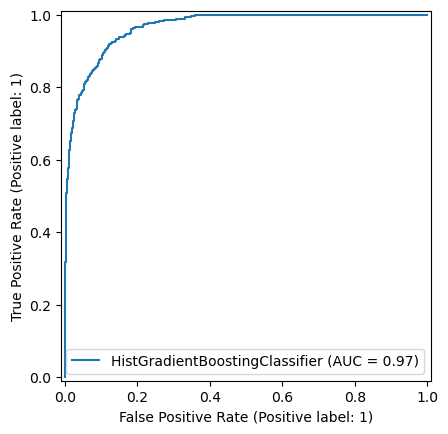

In [17]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

clf = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.07, max_leaf_nodes=31, random_state=0)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))
_ = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## 4) SHAP: compute global and local explanations

In [18]:

import shap
shap.initjs()

explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer(X_test)  # shap.Explanation
shap_values

.values =
array([[ 1.74884681e-01, -4.63107889e-02,  5.67746461e+00, ...,
         3.68365877e-01, -8.91094700e-03,  4.01870149e-01],
       [ 2.75701331e-01, -3.57230951e-01,  2.88246322e+00, ...,
         2.56991226e-01,  9.79488503e-02, -8.20421335e-01],
       [-5.66152194e-01,  4.13481596e-02, -5.51439895e+00, ...,
         1.48051233e+00,  4.73633075e-02,  1.25878275e-03],
       ...,
       [-1.33872533e-02, -7.40746625e-03, -5.19232824e+00, ...,
         4.10396658e-01, -3.99218242e-02, -9.40637864e-03],
       [ 4.13824542e-01,  2.99657551e-01,  2.10272115e+00, ...,
        -3.46815052e-01, -1.17815039e-01, -4.89759522e-01],
       [-2.50630999e-02,  8.12370018e-02, -4.31048533e+00, ...,
        -1.52104515e+00, -3.68822219e-02,  3.07366123e-01]],
      shape=(2000, 12))

.base_values =
array([-1.48840699, -1.48840699, -1.48840699, ..., -1.48840699,
       -1.48840699, -1.48840699], shape=(2000,))

.data =
array([[ 9.50853324e+02, -5.03629607e+01,  4.15356215e+01, ...,
       

### 4.1 Global importance: beeswarm & bar

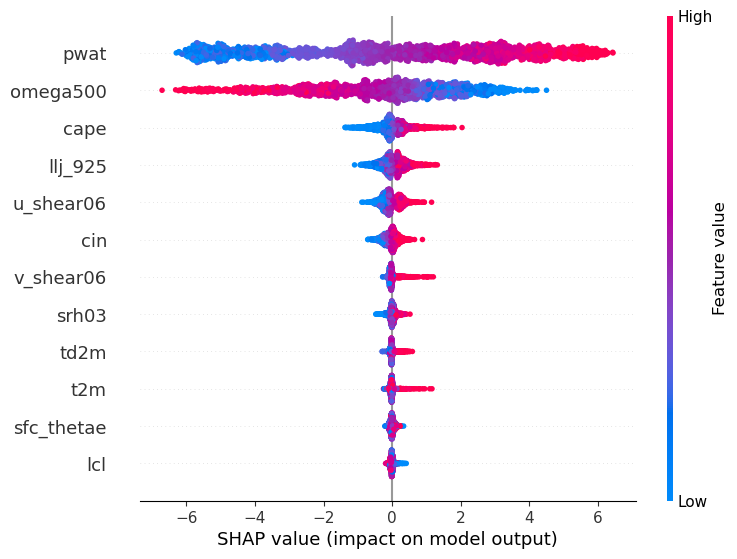

In [19]:

shap.plots.beeswarm(shap_values, max_display=12)

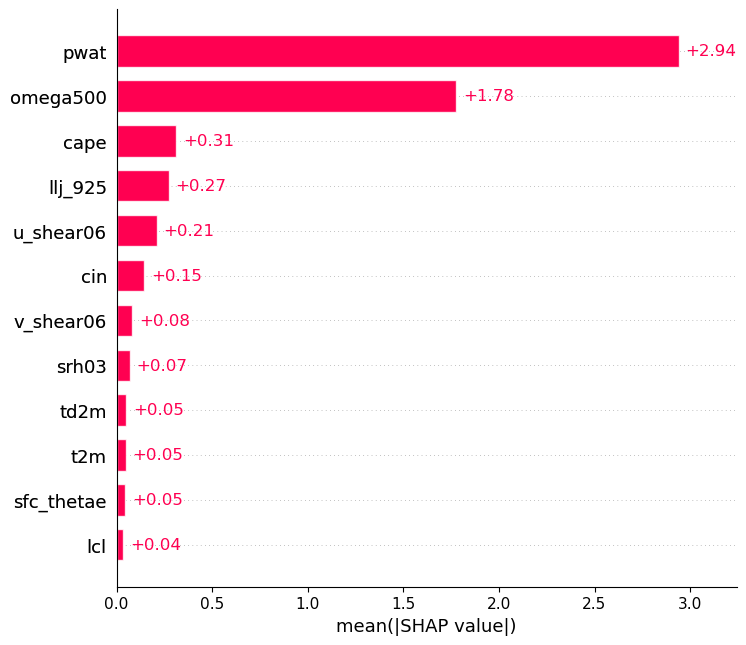

In [20]:

shap.plots.bar(shap_values, max_display=12)

### 4.2 Feature effects (dependence) with interaction coloring

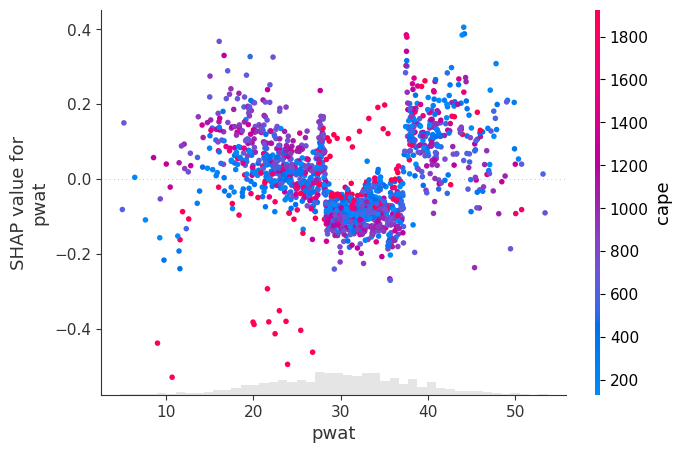

In [8]:

# PWAT dependence colored by strongest interaction automatically
shap.plots.scatter(shap_values[:, 'pwat'], color=shap_values)

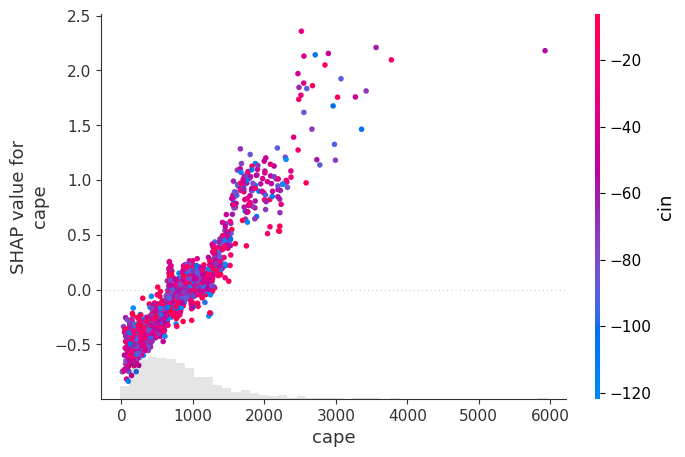

In [9]:

# CAPE dependence colored by CIN to reveal inhibition modulation
shap.plots.scatter(shap_values[:, 'cape'], color=shap_values[:, 'cin'])

### 4.3 Local explanations: waterfall and force plots

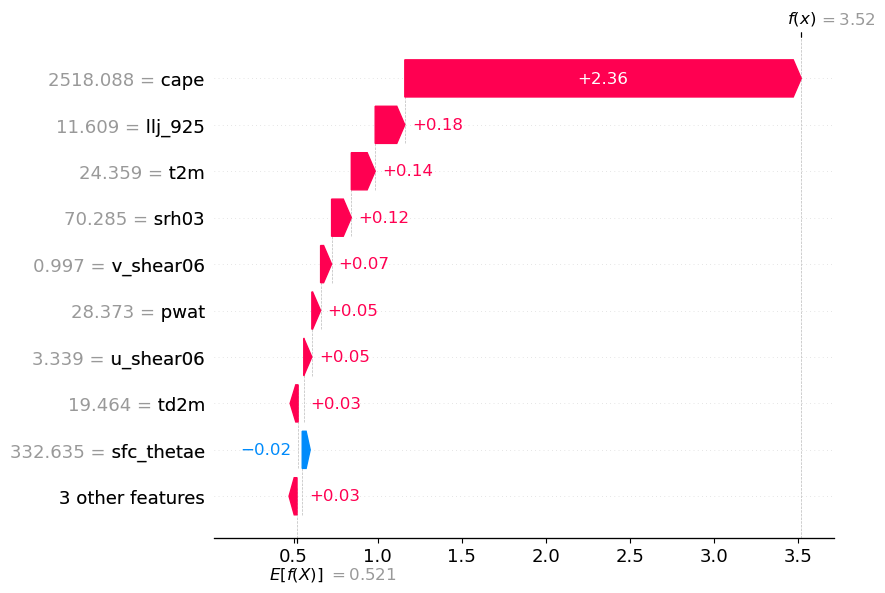

In [10]:

import numpy as np
idx = int(np.argmax(clf.predict_proba(X_test)[:,1]))
row = X_test.iloc[[idx]]

shap.waterfall_plot(shap.Explanation(
    values=shap_values.values[idx],
    base_values=shap_values.base_values[idx],
    data=row.values[0],
    feature_names=X.columns
))

In [11]:

# Interactive JS force plot (may not render in some environments; if so, set matplotlib=True)
shap.force_plot(shap_values.base_values[idx], shap_values.values[idx], row, matplotlib=False)

### 4.4 Interactive case browser (`ipywidgets`)

In [21]:

import ipywidgets as w
from IPython.display import display

probs = clf.predict_proba(X_test)[:,1]

@w.interact(i=w.IntSlider(min=0, max=len(X_test)-1, step=1, value=0, description='Case'))
def browse_case(i=0):
    row = X_test.iloc[[i]]
    display(row.style.set_caption(f"y_true={y_test[i]}, P(event)={probs[i]:.2f}"))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values.values[i],
        base_values=shap_values.base_values[i],
        data=row.values[0],
        feature_names=X.columns
    ))

interactive(children=(IntSlider(value=0, description='Case', max=1999), Output()), _dom_classes=('widget-inter…

## 5) Best practices for atmospheric SHAP

1. **Correlation-aware interpretation:** PWAT, Td, and \(\theta_e\) share moisture information—SHAP may split credit. Consider indices or feature groups.

2. **Background/reference data:** Use a climatology or non-event sample as SHAP background to ground contributions.

3. **Spatial/temporal leakage:** Use **blocked** CV (by date/storm/region). SHAP does not fix leakage.

4. **Units & scaling:** Label axes with meteorological units. SHAP values are in log-odds units for classifiers.

5. **Decision thresholds:** Couple SHAP with reliability and cost–loss for actionable thresholds.

### Bonus: simple reliability curve

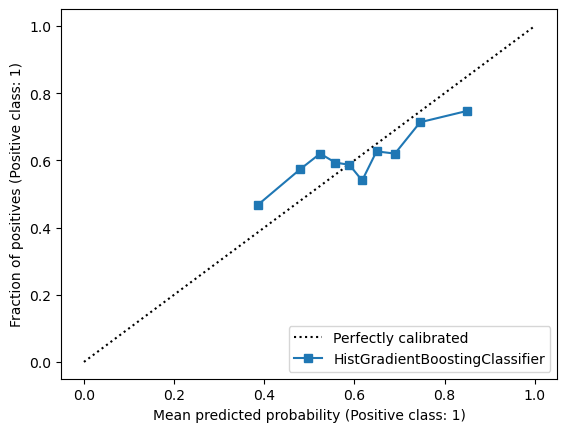

In [13]:

from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=10, strategy='quantile')

## 6) Swapping in real data (ERA5/IMERG or campaign)

Below is a sketch; adapt to your pipelines.

```python
import xarray as xr, pandas as pd
era = xr.open_zarr("era5.zarr").sel(time=slice("2015","2020"))
imerg = xr.open_dataset("IMERG_3H.nc").sel(time=era.time)

df = pd.DataFrame({
  'cape': era['CAPE'].sel(level=0).mean(['lat','lon']).to_pandas(),
  'pwat': era['TCWV'].mean(['lat','lon']).to_pandas(),
  'omega500': era['w'].sel(level=500).to_pandas(),
  # ...
})
y = (imerg['precip_rate_3h'].mean(['lat','lon']).to_pandas() >= 10).astype(int)
X = df.align(y, axis=0, join='inner')[0]
y = y.loc[X.index]
```

## 7) Assignment

- Produce global SHAP plots; two dependence plots (PWAT|omega500, CAPE|CIN).
- Analyze one **hit** and one **false alarm** with local SHAP; discuss plausibility.
- Reflect on correlation, leakage, and thresholding choices.